# Notebook settings
This notebook is a universal frame for training the BERT + Adapted C-HMCNN model. It can take in any Parquet dataset with suitable configuration.

**This version is for datasets with separate Parquets for training, validation and test sets.**

In [1]:
### Dataset configuration
# The main folder. It should be located inside datasets/. Inside it should be three .parquet folders or files.
DATASET_NAME   = 'DBPedia'
# The input text column
TEXT_COL_NAME  = 'text'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 3

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the batchrenorm pip package installed for the current env, flip this to True. 
CLONE_BATCH_RENORM = False
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

# Batch renormalisation
if CLONE_BATCH_RENORM:
    !pip install git+https://github.com/ludvb/batchrenorm@master
from batchrenorm import BatchRenorm1d

Using cuda


# Import data
We use Parquet datasets, stored inside the `datasets` folder of this repository.

In [3]:
data = dd.read_parquet('../../datasets/{}/train.parquet'.format(DATASET_NAME))
data_val = dd.read_parquet('../../datasets/{}/val.parquet'.format(DATASET_NAME))
data_test = dd.read_parquet('../../datasets/{}/val.parquet'.format(DATASET_NAME))
data.head(10)

,category,title,description,brand,feature
index,,,,,
0,"[Dairy, Cheese & Eggs, Cheese, Gouda]",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS,Ariola Imports,[]
1,"[Cooking & Baking, Sugar Substitutes, Xylitol]",Trim Healthy Mama Xylitol,"Shipped from UK, please allow 10 to 21 busines...",,[]
2,"[Cooking & Baking, Frosting, Icing & Decoratio...",Letter C - Swarovski Crystal Monogram Wedding ...,Jazz up your cakes with a sparkling monogram f...,Unik Occasions,[]
3,"[Cooking & Baking, Frosting, Icing & Decoratio...",Letter H - Swarovski Crystal Monogram Wedding ...,"Large Letter - Height 4.75""",Other,"[Large Letter - Height 4.75""]"
4,"[Cooking & Baking, Frosting, Icing & Decoratio...",Letter S - Swarovski Crystal Monogram Wedding ...,"4.75""",Unik Occasions,"[4.75"" height]"
5,"[Cooking & Baking, Frosting, Icing & Decoratio...",Letter J - Swarovski Crystal Monogram Wedding ...,"Large Letter - Height 4.75""",Other,"[Large Letter - Height 4.75""]"
6,"[Cooking & Baking, Frosting, Icing & Decoratio...",1 X Fully Covered in Crystal Monogram Wedding ...,"Large Letter - Height 4.75""",Unik Occasions,"[Large Letter - Height 4.75""]"
7,"[Cooking & Baking, Frosting, Icing & Decoratio...",Fully Covered in Crystal Monogram Wedding Cake...,"Large Letter - Height 4.75""",Other,"[Large Letter - Height 4.75""]"
8,"[Cooking & Baking, Frosting, Icing & Decoratio...",Letter L - Swarovski Crystal Monogram Wedding ...,"Large Letter - Height 4.75""",Other,"[Large Letter - Height 4.75""]"


# Prepare category hierarchy

## Categorical-encode the classes
Classification will be done by C-HMCNN (our own implementation). For this to work, we need a one-hot-encoded label set, which is compatible with BCELoss. We also extract the numerical labels for those classes from the one-hot encodings for convenience (i.e. for rendering a human-readable test output and to build the hierarchy from the list of name strings).

For categorical encoding to work, the column itself must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

To ease parsing, we'll follow a HMCN-like scheme in which labels are clumped together by their levels, i.e. the order would be all labels on level 1, then followed by all labels on level 2, and so on.

We'll only do the scanning step over the training set, that is, we'll assume that the training set is decent enough to include at least one example for every class.

In [4]:
def preprocess_classes(data, original_name, depth, verbose=False):
    """
    Build a list of unique class names for each level and create bidirectional mappings.
    """
    cls2idx = []
    idx2cls = []
    for i in range(depth): 
        category_li = data[original_name].apply(
            lambda lst: lst[i], meta=(original_name, 'object')
        ).astype('category').cat.as_known()
        if verbose:
            print(category_li.cat.categories)
        cls2idx.append(dict([
            (category, index) 
            for (index, category) 
            in enumerate(category_li.cat.categories)
        ]))
        idx2cls.append(list(category_li.cat.categories))
    return cls2idx, idx2cls

def class_to_index(data, original_name, cls2idx, depth):
    data['codes'] = data[original_name].apply(
        lambda lst: [
            cls2idx[i][cat] 
            for (i, cat) 
            in enumerate(lst[:depth])
        ],
        meta=(original_name, 'object')
    ).astype('object')

cls2idx, idx2cls = preprocess_classes(data, CLASS_COL_NAME, DEPTH)
    
print('Class-to-index mapping:', cls2idx, '\n')
print('Index-to-class mapping:', idx2cls, '\n')

# Now take those mappings and convert those class names to numbers
class_to_index(data, CLASS_COL_NAME, cls2idx, DEPTH)
class_to_index(data_val, CLASS_COL_NAME, cls2idx, DEPTH)
class_to_index(data_test, CLASS_COL_NAME, cls2idx, DEPTH)

print('Data preview:', data['codes'].head(10))

Class-to-index mapping: [{'Alcoholic Beverages': 0, 'Beverages': 1, 'Breads & Bakery': 2, 'Breakfast Foods': 3, 'Candy & Chocolate': 4, 'Canned, Jarred & Packaged Foods': 5, 'Coffee, Tea & Cocoa': 6, 'Condiments & Salad Dressings': 7, 'Cooking & Baking': 8, 'Dairy, Cheese & Eggs': 9, 'Dried Beans, Grains & Rice': 10, 'Food & Beverage Gifts': 11, 'Fresh Flowers & Live Indoor Plants': 12, 'Frozen': 13, 'Herbs, Spices & Seasonings': 14, 'Jams, Jellies & Sweet Spreads': 15, 'Meat & Seafood': 16, 'Meat Substitutes': 17, 'Olives, Pickles & Relishes': 18, 'Packaged & Sliced Deli Meats': 19, 'Pasta & Noodles': 20, 'Prepared Foods': 21, 'Produce': 22, 'Sauces, Gravies & Marinades': 23, 'Snack Foods': 24, 'Soups, Stocks & Broths': 25}, {'Antipasto': 0, 'Appetizers': 1, 'Appetizers & Snacks': 2, 'Applesauce & Fruit Cups': 3, 'Asian Noodle Soups': 4, 'Assortments & Variety Gifts': 5, 'Bacon': 6, 'Bakery & Dessert Gifts': 7, 'Baking Chocolates, Carob & Cocoa': 8, 'Baking Mixes': 9, 'Beans': 10, 'Be

Data preview: index
0     [9, 39]
1    [8, 230]
2     [8, 95]
3     [8, 95]
4     [8, 95]
5     [8, 95]
6     [8, 95]
7     [8, 95]
8     [8, 95]
9     [8, 95]
Name: codes, dtype: object


In [5]:
from functools import reduce
# C-HMCNN needs global-space indices. As such we need to offset the level codes.
# We still make use of the local-space code above to increase commonality with other models.
def index_to_binary(data, index_col_name, offsets, sz, verbose=False):
    if verbose:
        print('Using offsets:', offsets)
    
    def generate_binary(codes):
        b = np.zeros(sz, dtype=int)
        indices = np.array(codes, dtype=int) + offsets[:-1] - 1
        if verbose:
            print(codes, offsets, indices)
        b[indices] = 1
        return b.tolist()
    
    data[index_col_name + '_b'] = data[index_col_name].apply(
        lambda lst: generate_binary(lst),
        meta=(index_col_name + '_b', 'object')
    )
    
level_sizes = [*map(lambda lst: len(lst), idx2cls)]
level_offsets = np.array(reduce(lambda acc, elem: acc + [acc[-1] + elem], level_sizes, [0]))

index_to_binary(data, 'codes', level_offsets, sum(level_sizes), verbose=False)
index_to_binary(data_val, 'codes', level_offsets, sum(level_sizes), verbose=False)
index_to_binary(data_test, 'codes', level_offsets, sum(level_sizes), verbose=False)

print(data['codes_b'].head(10))

index
0    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
8    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: codes_b, dtype: object


## Build an ancestry matrix
Let $n_D$ = number of classes we have up to depth $D$ of the hierarchy, build a matrix $M_D$ of size $n_D \times n_D$ where $M_{i,j} = 1$ if label with code $i$ is an ancestor of label with code $j$ and 0 otherwise.

For example in an e-commerce product dataset, if a category named 'Sports' of code 0 has a subcategory named 'Outdoor Sports' of code 100, then $M_{0, 100} = 1$. Intuitively, every row represents the parentship of each category.

One important thing to note here is that the set of subclasses contains the parent class itself. This is key to C-HMCNN's ability to uphold the hierarchy.

In [6]:
def build_ancestry_matrix(codes, level_sizes):
    n = sum(level_sizes)
    offsets = np.array([0] + level_sizes, dtype=int)
    result = np.zeros((n, n), dtype=bool)
    np.fill_diagonal(result, 1) # In our case, every category is an ancestor of itself
    for lst in tqdm(codes):
        for i, ancestor in enumerate(lst):
            ancestor_idx = ancestor + offsets[i] - 1
            for j, offspring in enumerate(lst[i+1:]):
                offspring_idx = offspring + offsets[j+i+1] - 1
                result[ancestor_idx, offspring_idx] = 1
    return result

# Pass n separately for easier Dask integration later, as iloc doesn't work
M = build_ancestry_matrix(data['codes'], level_sizes)
M = torch.tensor(M).to(device)
M

  0%|          | 0/235936 [00:00<?, ?it/s]

tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')

## Checkpoints

In [7]:
def load_checkpoint(checkpoint_fpath, model, optimizer=None):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

def save_checkpoint(state, is_best, checkpoint_path, best_checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_checkpoint_path: path to save best model
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_checkpoint_path
        shutil.copyfile(f_path, best_fpath)

## Metrics function
We define hierarchical accuracy as simply the averaged accuracy over each level. Same for precision.
In addition to those, at the end of the testing phase we'll also compute the average area under the precision-recall curve (AU(PRC)).

In [8]:
def get_metrics(outputs, targets, level_sizes, print_metrics=True):
    offsets = [0] + level_sizes
    level_codes = [ 
        np.argmax(outputs[:, offsets[level] : offsets[level + 1]], axis=1) + offsets[level] 
        for level in range(len(level_sizes)) 
    ]
    
    target_codes = np.array([ np.nonzero(lst)[0] for lst in targets ], dtype=int)
    
    accuracies = [ metrics.accuracy_score(level_codes[level], target_codes[:, level]) for level in range(len(level_sizes)) ]
    precisions = [ metrics.precision_score(level_codes[level], target_codes[:, level], average='weighted') for level in range(len(level_sizes)) ]
    
    global_accuracy = sum(accuracies)/len(accuracies)
    global_precision = sum(precisions)/len(precisions)
    
    if print_metrics:
        for i in range(len(level_sizes)):
            print('Level {}:'.format(i))
            print("Accuracy:", accuracies[i])
            # Model Precision: what percentage of positive tuples are labeled as such?
            print("Precision:", precisions[i],'\n')
        print('Path average:')
        print('Accuracy:', global_accuracy)
        print('Precision:', global_precision)
    
    return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision])

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [9]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

In [10]:
from torch.utils.data import IterableDataset
class CustomDataset(IterableDataset):
    def __init__(self, df, tokenizer, max_len, text_col_name = TEXT_COL_NAME):
        self.tokenizer = tokenizer
        self.iterator = df.itertuples()
        self.max_len = max_len

    def __iter__(self):
        return self

    def __next__(self):
        row = next(self.iterator)
        text = str(getattr(row, TEXT_COL_NAME))
        text = " ".join(text.split())
        inputs = self.tokenizer(
            text,
            None, # No text_pair
            add_special_tokens=True, # CLS, SEP
            max_length=self.max_len, # For us it's a hyperparam. See next cells.
            padding='max_length',
            truncation=True
            # BERT tokenisers return attention masks by default
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(getattr(row, 'codes_b'), dtype=torch.float)
        }

Regarding that `max_len` hyperparameter, let's see the distribution of string lengths:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('title', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

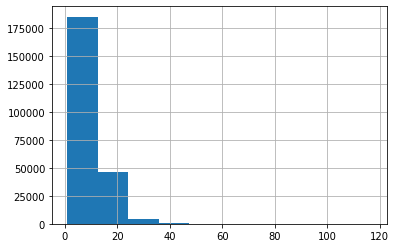

In [11]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings. Here it seems 64 will do.

In [12]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

# Customize these settings for training from scratch.
config = {
    'epochs': 5,
    'encoder_lr': 2e-05,
    'classifier_lr': 5e-04,
    'h_dropout': 0.7,
    'h_nonlinear': 'relu',
    'h_hidden_dim': 512,
    'h_layer_count': 3,
}

### Don't change these if you need to compare with published results
MAX_LEN = 64
TRAIN_MINIBATCH_SIZE = 16
VAL_TEST_MINIBATCH_SIZE = 64

# Don't touch this part
train_minibatch_count = len(data) // TRAIN_MINIBATCH_SIZE
val_minibatch_count = len(data_val) // VAL_TEST_MINIBATCH_SIZE
test_minibatch_count = len(data_test) // VAL_TEST_MINIBATCH_SIZE

mkdir: cannot create directory ‘checkpoints-Grocery_and_Gourmet_Food.parquet’: File exists


## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by a dropout layer and a linear layer for leaf category classification.

In [16]:
def get_constr_out(x, M):
    n = M.shape[1]
    H = x.unsqueeze(1) # Add a new dimension
    # Duplicate x along the new dimension to create a list of 2D matrices
    # of size n x n (same as R). Note that x can be a list of vectors instead of one.
    H = H.expand(len(x), n, n)
    # We'll have to duplicate R to multiply with the entire batch here
    M_batch = M.expand(len(x), n, n)
    final_out, _ = torch.max(M_batch*H, dim = 2)
    return final_out

class H_MCM_Model(torch.nn.Module):
    def __init__(self, input_dim, output_dim, config, M):
        super(H_MCM_Model, self).__init__()

        self.layer_count = config['h_layer_count']
        self.M = M

        fc = []
        if self.layer_count == 1:
            fc.append(torch.nn.Linear(input_dim, output_dim))
        else:
            for i in range(self.layer_count):
                if i == 0:
                    fc.append(torch.nn.Linear(input_dim, config['h_hidden_dim']))
                elif i == self.layer_count - 1:
                    fc.append(torch.nn.Linear(config['h_hidden_dim'], output_dim))
                else:
                    fc.append(torch.nn.Linear(config['h_hidden_dim'], config['h_hidden_dim']))

        self.fc = torch.nn.ModuleList(fc)    
        self.drop = torch.nn.Dropout(config['h_dropout'])
        self.sigmoid = torch.nn.Sigmoid()
        if config['h_nonlinear'] == 'tanh':
            self.f = torch.nn.Tanh()
        else:
            self.f = torch.nn.ReLU()

    def forward(self, x):
        for i in range(self.layer_count):
            if i == self.layer_count - 1:
                x = self.sigmoid(self.fc[i](x))
            else:
                x = self.f(self.fc[i](x))
                x = self.drop(x)
        if self.training:
            return x
        return get_constr_out(x, self.M)

In [17]:
encoder = base_encoder
encoder.load_state_dict(base_encoder_state)
encoder.to(device)

class DistilBERTClass(torch.nn.Module):
    def __init__(self, output_count, M):
        super(DistilBERTClass, self).__init__()
        self.l1 = encoder
        self.renorm = BatchRenorm1d(768)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = H_MCM_Model(768, output_count, config, M)
    def forward(self, ids, mask):
        output_1 = self.l1(ids, attention_mask = mask)[0][:,0,:]
        output_2 = self.l2(self.renorm(output_1))
        output = self.l3(output_2)
        return output

model = DistilBERTClass(sum(level_sizes), M)

model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

# Training time

In [18]:
#!/usr/bin/env python

from tqdm.notebook import tqdm

def train_model(config, data, data_val, model, checkpoint_path, best_checkpoint_path, level_sizes):
    
    output_sz = sum(level_sizes)
    
    criterion = torch.nn.BCELoss()

    optimizer = torch.optim.Adam(
        [
            {'params': model.l1.parameters(), 'lr': config['encoder_lr'],},
            {'params': model.l3.parameters(), 'lr': config['classifier_lr']}
        ], 
    )
    val_loss_min = np.Inf
    # Store validation metrics after each epoch
    val_metrics = np.empty((4, 0), dtype=float)
    for epoch in range(1, config['epochs'] + 1):
        train_set = CustomDataset(data, tokenizer, MAX_LEN)
        val_set = CustomDataset(data_val, tokenizer, MAX_LEN)

        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=TRAIN_MINIBATCH_SIZE)
        val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=VAL_TEST_MINIBATCH_SIZE)
        train_loss = 0
        val_loss = 0
        # Put model into training mode. Note that this call DOES NOT train it yet.
        model.train()
        print('Epoch {}: Training'.format(epoch))
        for batch_idx, data in enumerate(tqdm(train_loader, total=train_minibatch_count)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.double)

            outputs = model(ids, mask)

            # Notation: H = output stacked, Hbar = hbar stacked
            constr_outputs = get_constr_out(outputs, M) # MCM = max(M * H, dim=1)
            train_outputs = targets * outputs.double() # hbar = y * h
            train_outputs = get_constr_out(train_outputs, M) # max(M * Hbar, dim = 1)

            # (1-y) + max(M * H, dim = 1) + y * max(M * Hbar, dim = 1) versus y
            train_outputs = (1-targets)*constr_outputs.double() + targets*train_outputs
            loss = criterion(train_outputs, targets)

            predicted = constr_outputs.data > 0.5

            # PyTorch defaults to accumulating gradients. That's half of what Adam is.
            # but we are working on a new batch each time this runs, so we still have
            # to clear.
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            #print('after loss data in training', loss.item(), train_loss)

        print('Epoch {}: Validating'.format(epoch))

        # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
        model.eval()

        current_val_targets = np.empty((0, output_sz), dtype=np.float32)
        current_val_outputs = np.empty((0, output_sz), dtype=np.float32)
        # We're only testing here, so don't run the backward direction (no_grad).
        with torch.no_grad():
            for batch_idx, data in tqdm(enumerate(val_loader), total=val_minibatch_count):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['labels'].to(device, dtype = torch.double)

                constrained_outputs = model(ids, mask).double()

                loss = criterion(constrained_outputs, targets)

                val_loss = val_loss + ((1 / (batch_idx + 1)) * (loss.item() - val_loss))

                current_val_targets = np.concatenate(
                    [
                        current_val_targets,
                       targets.cpu().detach().numpy()
                    ]
                )
                current_val_outputs = np.concatenate(
                    [
                        current_val_outputs,
                       constrained_outputs.cpu().detach().numpy()
                    ]
                )

        train_loss = train_loss/train_minibatch_count
        val_loss = val_loss/val_minibatch_count
        print('Average training loss: {:.6f}\nAverage validation loss: {:.6f}'.format(
            train_loss,
            val_loss
        ))
        
        val_metrics = np.concatenate([val_metrics, 
            np.expand_dims(
                get_metrics(current_val_outputs, current_val_targets, level_sizes), axis=1
            )],
            axis=1
        )

        # create checkpoint variable and add important data
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        # save checkpoint
        best_yet = False
        if val_loss <= val_loss_min:
            best_yet = True
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving best copy...'.format(val_loss_min,val_loss))
            # save checkpoint as best model
            val_loss_min = val_loss
        save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
        print('Epoch {}: Done\n'.format(epoch))
    return model, val_metrics

# Alternative: just load from disk
def run_model(model, loader, level_sizes, minibatch_count=None):
    output_sz = sum(level_sizes)
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    model.eval()

    all_targets = np.empty((0, output_sz), dtype=np.float32)
    all_outputs = np.empty((0, output_sz), dtype=np.float32)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(loader, total=minibatch_count)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.long)

            constrained_outputs = model(ids, mask).double()
            
            all_targets = np.concatenate([all_targets, targets.cpu().detach().numpy()])
            all_outputs = np.concatenate([
                all_outputs,
                constrained_outputs.cpu().detach().numpy()
           ])

    return {
        'targets': all_targets,
        'outputs': all_outputs,
    }

Epoch 1: Training


  0%|          | 0/11797 [00:00<?, ?it/s]

Epoch 1: Validating
Average training loss: 0.000001
Average validation loss: 0.000033
Level 0:
Accuracy: 0.8255488683563618
Precision: 0.8371467020347642 

Level 1:
Accuracy: 0.6879291345257269
Precision: 0.7944055199841163 

Path average:
Accuracy: 0.7567390014410443
Precision: 0.8157761110094403
Validation loss decreased (inf --> 0.000033). Saving best copy...
Epoch 1: Done

Epoch 2: Training


  0%|          | 0/11797 [00:00<?, ?it/s]

Epoch 2: Validating
Average training loss: 0.000001
Average validation loss: 0.000032
Level 0:
Accuracy: 0.8438162244638467
Precision: 0.8590204366592921 

Level 1:
Accuracy: 0.7111977621429177
Precision: 0.8091149065136661 

Path average:
Accuracy: 0.7775069933033822
Precision: 0.8340676715864791
Validation loss decreased (0.000033 --> 0.000032). Saving best copy...
Epoch 2: Done

Epoch 3: Training


  0%|          | 0/11797 [00:00<?, ?it/s]

Epoch 3: Validating
Average training loss: 0.000001
Average validation loss: 0.000033
Level 0:
Accuracy: 0.851614817326439
Precision: 0.858276920077152 

Level 1:
Accuracy: 0.7212003051623294
Precision: 0.8013463289532455 

Path average:
Accuracy: 0.7864075612443842
Precision: 0.8298116245151987


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Done

Epoch 4: Training


  0%|          | 0/11797 [00:00<?, ?it/s]

Epoch 4: Validating
Average training loss: 0.000001
Average validation loss: 0.000032
Level 0:
Accuracy: 0.8488174959735526
Precision: 0.8599884571699182 

Level 1:
Accuracy: 0.7248029159955921
Precision: 0.8114023215392433 

Path average:
Accuracy: 0.7868102059845723
Precision: 0.8356953893545808


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Done

Epoch 5: Training


  0%|          | 0/11797 [00:00<?, ?it/s]

Epoch 5: Validating
Average training loss: 0.000001
Average validation loss: 0.000032
Level 0:
Accuracy: 0.8516572009833009
Precision: 0.860120362222471 

Level 1:
Accuracy: 0.7286174451131644
Precision: 0.8009968118606776 

Path average:
Accuracy: 0.7901373230482327
Precision: 0.8305585870415744


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Done



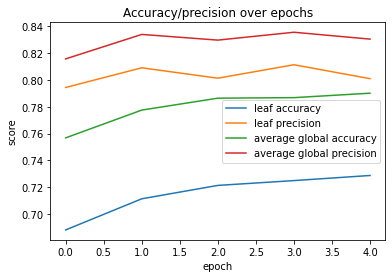

In [19]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        train_loader, 
        val_loader, 
        model,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
        level_sizes
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.plot(x, val_metrics[2], label='average global accuracy')
    ax.plot(x, val_metrics[3], label='average global precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, model)

In [20]:
test_set = CustomDataset(data_test, tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=VAL_TEST_MINIBATCH_SIZE)
test_result = run_model(trained_model, test_loader, level_sizes, test_minibatch_count)

  0%|          | 0/369 [00:00<?, ?it/s]

# Evaluation

In [21]:
test_outputs = test_result['outputs']
test_targets = test_result['targets']
test_outputs

array([[5.89908566e-03, 1.80629795e-04, 1.73067558e-04, ...,
        2.47768095e-09, 2.25635022e-09, 3.67179565e-10],
       [4.21092082e-05, 9.40630169e-13, 6.35391389e-16, ...,
        6.21053427e-25, 2.73599642e-24, 5.17127573e-12],
       [1.79614086e-04, 1.70979838e-05, 5.99756640e-06, ...,
        3.70602167e-16, 1.05661858e-13, 7.83186304e-16],
       ...,
       [7.19110370e-02, 1.09811217e-01, 2.69090161e-02, ...,
        1.45825734e-05, 8.79467843e-05, 2.22217321e-04],
       [1.80588383e-02, 5.14122099e-03, 1.83325610e-03, ...,
        4.96637085e-06, 8.19773777e-06, 2.53564558e-05],
       [4.14887438e-07, 8.37656842e-08, 1.73170793e-08, ...,
        4.36891726e-20, 9.51628877e-17, 3.14587531e-21]])

In [22]:
get_metrics(test_result['outputs'], test_result['targets'], level_sizes)

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]))], axis=0)
rectified_targets = np.concatenate([test_result['targets'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Level 0:
Accuracy: 0.8549569787648879
Precision: 0.8631194155529616 

Level 1:
Accuracy: 0.7324206332386725
Precision: 0.8059663256298576 

Path average:
Accuracy: 0.7936888060017802
Precision: 0.8345428705914095


Rectified leaf-level AU(PRC) score: 0.5711538220882181
